### Submission by Durgesh Vikram Yadav (2011MT10)

# FB Dataset

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime
import matplotlib.pyplot as plt 
import warnings
warnings.simplefilter('ignore')

In [2]:
#Downloading data
fb = pdr.DataReader('FB', 'yahoo', start=datetime(2014, 8, 1), end=datetime(2016, 11, 30))

In [3]:
#Exporting and saving as csv files
fb.to_csv('Facebook_stock.csv', sep=',')

In [4]:
#Printing the first few lines of data
fb.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-08-01,73.220001,71.550003,72.220001,72.360001,43535000,72.360001
2014-08-04,73.879997,72.360001,72.360001,73.510002,30777000,73.510002
2014-08-05,73.589996,72.180000,73.199997,72.690002,34986000,72.690002
2014-08-06,73.720001,71.790001,72.019997,72.470001,30986000,72.470001
2014-08-07,74.000000,72.699997,73.000000,73.169998,38141000,73.169998


Text(0.5, 1.0, 'Close Price history vs Time')

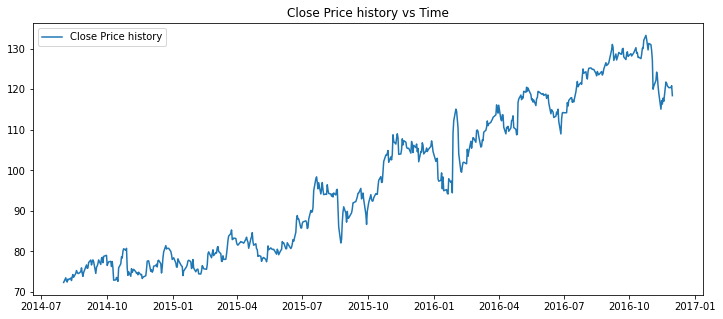

In [5]:
#Visulaizing the data
plt.figure(figsize=(12,5))
plt.plot(fb['Close'], label='Close Price history')
plt.legend()
plt.title('Close Price history vs Time')

# ARIMA Model

In [6]:
# Installing pmdarima package
!pip3 install pmdarima

     |████████████████████████████████| 1.5MB 20.5MB/s 
     |████████████████████████████████| 9.5MB 39.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
# Importing ARIMA libraries
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [8]:
stepwise_model = auto_arima(fb["Close"], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2255.047, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2255.572, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2255.520, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2254.385, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.876 seconds
2254.385067862553


In [9]:
data = fb['Close'].dropna().to_numpy()
n = int(len(data)*0.7)
train, test = data[:n], data[n:]

In [10]:
# Fitting Model
model = ARIMA(data, order=(1, 0, 1))
model_fit = model.fit()

In [11]:
# Make Prediction
from sklearn.metrics import mean_squared_error
from math import sqrt

yhat = model_fit.predict(0,len(data)-1)
rmse = sqrt(mean_squared_error(data, yhat))
print('RMSE Value is: ',rmse)

RMSE Value is:  1.914996479972129


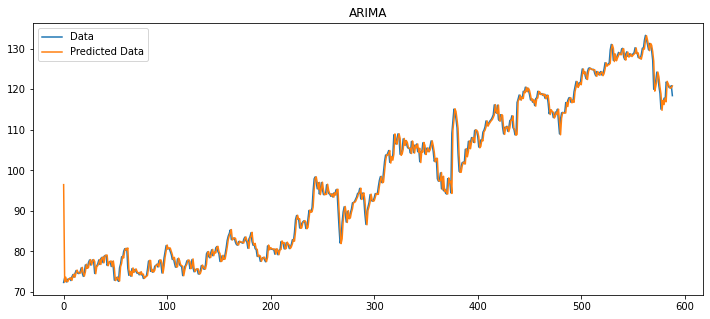

In [12]:
# Visualize Results
plt.figure(figsize=(12,5))
plt.plot(data,label='Data')
plt.plot(yhat,label='Predicted Data')
plt.title('ARIMA')
plt.legend()
plt.show()



---



---



---



# LSTM Model

In [13]:
# Imporint Libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [14]:
df1=fb['Close']
date = (fb.index)
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
# Splitting data
training_size = int(0.8*len(df1))
test_size = len(df1)-training_size
train_data = df1[0:training_size]
test_data = df1[training_size:len(df1)] 

In [16]:
# Converting to dataset matrix
def create_dataset(data, steps=1):
	dataX, dataY = [], []
	for i in range(len(data)-steps-1):
		a = data[i:(i+steps), 0]   
		dataX.append(a)
		dataY.append(data[i + steps, 0]) 
	return np.array(dataX), np.array(dataY) 

In [17]:
# Reshaping
steps = 5
X_train, y_train = create_dataset(train_data, steps)
X_test, ytest = create_dataset(test_data, steps)
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [18]:
# Fitting Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [20]:
# Inverse Transform
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(ytest.reshape(-1, 1))

In [21]:
# Train data RMSE
rmse1 = np.sqrt(np.mean(np.power((np.array(Y_train)-np.array(train_predict)),2)))
print('RMSE Value of train data with LSTM model',rmse1)

RMSE Value of train data with LSTM model 2.7178198551378427


In [22]:
# Test Data RMSE
rmse2 = np.sqrt(np.mean(np.power((np.array(Y_test)-np.array(test_predict)),2)))
print('RMSE Value of test data with LSTM model',rmse2)

RMSE Value of test data with LSTM model 2.5335806462646806


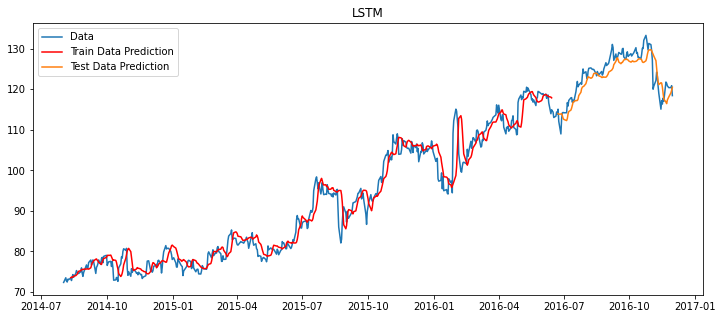

In [23]:
# Visulaize Predictions
pre=5
plt.figure(figsize=(12,5))
plt.plot(date,scaler.inverse_transform(df1), label='Data')
plt.plot(date[pre+1:training_size],train_predict, label='Train Data Prediction', color='red')
plt.plot(date[training_size+pre+1:],test_predict, label='Test Data Prediction')
plt.legend()
plt.title('LSTM')
plt.show()



---



---



---



# Exponential Smoothing

In [24]:
# Importing Libraries
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
data = fb['Close'].to_numpy()
date = (fb.index)

In [26]:
#Exponentital Smoothening
Exp_model = ExponentialSmoothing(fb.Close,trend='mul',seasonal='mul',seasonal_periods=4)
fb['Exp_Smoothening'] = Exp_model.fit(smoothing_level = 0.9,smoothing_slope= 0.1,smoothing_seasonal = 0.2).fittedvalues.shift(0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [27]:
#RMSE Value
rmse3 = np.sqrt(np.mean(np.power((np.array(data)-np.array(fb.Exp_Smoothening)),2)))
print('RMSE value with Exponential Smoothing: ',rmse3)

RMSE value with Exponential Smoothing:  1.888335218694675


Text(0.5, 1.0, 'Exponential Smoothing')

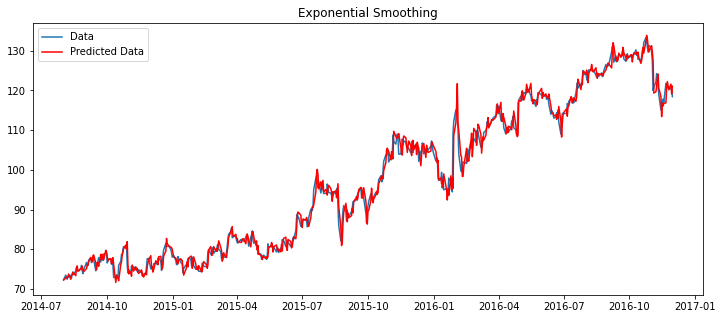

In [28]:
#Visulaize Data and Prediction
plt.figure(figsize=(12,5))
plt.plot(date,data, label='Data')
plt.plot(date,fb.Exp_Smoothening, label='Predicted Data',color = 'red')
plt.legend()
plt.title('Exponential Smoothing')



---



---



---



#Prohet Model

In [29]:
#Importing Library
from fbprophet import Prophet

In [30]:
#Adding Date Column to DataFrame
fb['Date'] = pd.date_range(start='8/1/2014', periods=len(fb.Close), freq='D')
fb_features = fb[['Date','Close']]
fb_features = fb_features.rename(columns = {"Date":"ds","Close":"y"})

In [31]:
#Applying Prophet model
fb_model = Prophet(daily_seasonality = True) # stock prices have daily seasonality
fb_model.fit(fb_features)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [32]:
#Predicting for future 30 days
future = fb_model.make_future_dataframe(periods = 30)
prediction = fb_model.predict(future)

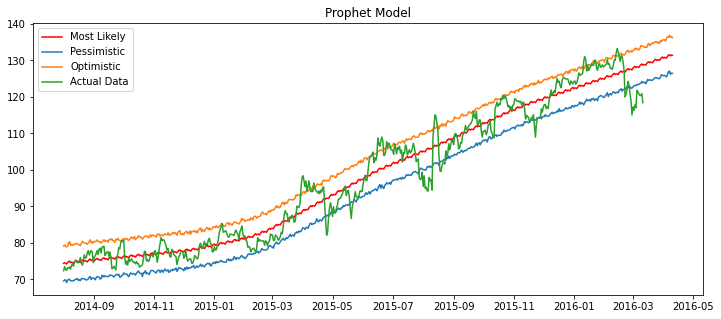

In [33]:
#Visualizing the results
plt.figure(figsize=(12,5))
plt.plot(prediction['ds'],prediction['yhat'],color='red',label='Most Likely')
plt.plot(prediction['ds'],prediction['yhat_lower'],label='Pessimistic')
plt.plot(prediction['ds'],prediction['yhat_upper'],label='Optimistic')
plt.plot(fb_features['ds'],fb_features['y'],label='Actual Data')
plt.legend()
plt.title('Prophet Model')
plt.show()

Among the 4 models applied on Facebook Dataset, LSTM Model gives higher RMSE Value. Also, it is evident from the plot that prediction for other models than LSTM are better, thus, we can use any of the ARIMA, Exponential Smoothening or Prophet Models.